## Лабораторная работа по курсу "Искусственный интеллект"
## Часть2

| Студент | Будникова|
|---------|--------|
| Группа  | M80-307Б-19      |


In [193]:
import torch as tr 
import torch.nn.functional as F
from torch import optim, nn
from torch.utils import data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import statistics as st
from sklearn import metrics
from importlib import reload
from scipy import interpolate

<h3>Данные для обучения(MNIST):</h3>

One batch:
features: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
labels: tensor([3, 1, 2, 7, 7, 1, 0, 8, 7, 6, 9, 4, 7, 0, 7, 9])


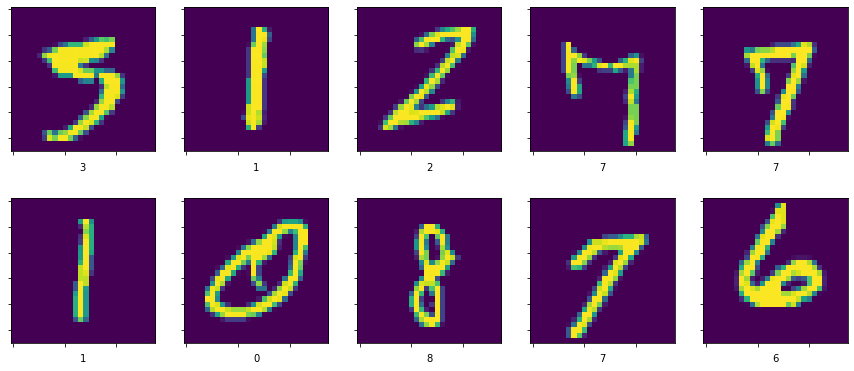

In [194]:
train_data = datasets.MNIST('data', train=True, download=False, transform=transforms.ToTensor())
train_x, test_x = data.random_split(train_data, [len(train_data) * 8 // 10, len(train_data) - len(train_data) * 8 // 10])

train_dataloader = data.DataLoader(train_x, batch_size=16)
test_dataloader = data.DataLoader(test_x, batch_size=len(test_x))


x, y = iter(train_dataloader).next()
x = x.view(x.size(0), -1)
print("One batch:")
print(f"features: {x}")
print(f"labels: {y}")

fig = plt.figure(figsize=(15, 10))
for i in range(min(len(x), 10)):
    ax = fig.add_subplot(3, 5, i+1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.imshow(x[i].reshape(28, 28))
    plt.xlabel(y[i].item())
plt.show()

<h3>Однослойный персептрон, классифицирующий датасет с точностью >85%</h3>

<h4>Модель и функция ошибки:</h4>

In [195]:
class Model:
    def __init__(self, countIn, countOut, learning_rate):
        self.W = tr.tensor(np.random.normal(0.1, 1.0 / np.sqrt(countIn), (countIn, countOut)), requires_grad=True, dtype=tr.float32)
        self.b = tr.tensor(np.zeros((1, countOut)), requires_grad=True)
        self.lr = learning_rate
        self.loss_func = nn.CrossEntropyLoss()
        self.acc = 0
    
    def forward(self, x):
        z = tr.matmul(x, self.W) + self.b
        p = F.log_softmax(z, dim=-1)
        return p
    
    def train(self, x, y):
        predictions = self.forward(x)
        
        loss = self.loss_func(predictions, y)

        self.acc = tr.mean((tr.argmax(predictions, dim=1) == y).float())

        loss.backward()

        self.W.data.sub_(self.lr * self.W.grad)
        self.b.data.sub_(self.lr * self.b.grad)
        
        self.W.grad.zero_()
        self.b.grad.zero_()
        return loss

    def plot_ConfusionMatrix(self, y_true, y_pred, labels):
        print("ConfusionMatrix:")
        c_matr = metrics.confusion_matrix(y_true, y_pred) 
        disp = metrics.ConfusionMatrixDisplay(c_matr)
        fig, ax = plt.subplots(figsize=(10,10));
        disp.plot(ax=ax);
        ax.xaxis.set_ticklabels(labels);
        ax.yaxis.set_ticklabels(labels);

    def test(self, x, y, labels):
        predictions = self.forward(x)
        val_predictions = tr.argmax(predictions, dim=1)
        
        acc = tr.mean((val_predictions == y).float())
        acc = (int)(acc * 100)

        print("Test:")
        print(f"Accuracy: {acc}%")

        self.plot_ConfusionMatrix(y.numpy(), val_predictions.detach().numpy(), labels)
        

<h4>Обучение:</h4>

In [196]:
mod = Model(784, 10, 0.01)
epoch = 5
ep_loss = list()
for e in range(epoch):
    acc = list()
    losses = list()
    for (x, y) in train_dataloader:
        x = x.view(x.size(0), -1)
        loss = mod.train(x, y)
        losses.append(loss.item())
        acc.append(mod.acc.item())
    loss = round(st.mean(losses), 3)
    ep_loss.append(loss)
    accuracy = (int)(st.mean(acc) * 100)
    print(f"Epoch: {e}     loss: {loss} accuracy: {accuracy}%")



Epoch: 0     loss: 0.66 accuracy: 84%
Epoch: 1     loss: 0.406 accuracy: 89%
Epoch: 2     loss: 0.365 accuracy: 89%
Epoch: 3     loss: 0.344 accuracy: 90%
Epoch: 4     loss: 0.331 accuracy: 90%


<h4>Поведение функции потерь при обучении </h4>

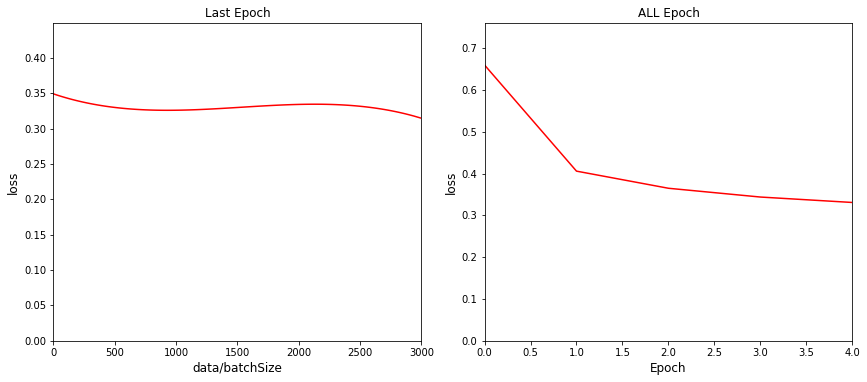

In [197]:
plt = reload(plt)
def PlotLoss(x1, y1, title1, x2, y2, titel2):
    fig = plt.figure(figsize=(30, 15))
    ax1 = fig.add_subplot(3, 5, 1)
    ax2 = fig.add_subplot(3, 5, 2)

    y = y1
    x = x1
    spl = interpolate.UnivariateSpline(x, y, k = 3)
    xx = np.arange(len(y))[::len(y) // 100]
    xx[-1] = len(y)
    ax1.plot(xx, spl(xx), 'r-')
    ax1.axis([0, len(x), 0, max(spl(x)) + 0.1])
    ax1.set_title(title1)
    ax1.set_xlabel("data/batchSize", size=12)
    ax1.set_ylabel("loss", size=12)

    ax2.plot(x2, y2, 'r-')
    ax2.axis([0, len(y2) - 1, 0, max(y2) + 0.1])
    ax2.set_title(titel2)
    ax2.set_xlabel("Epoch", size=12)
    ax2.set_ylabel("loss", size=12)

    fig.tight_layout()
    plt.show()

PlotLoss(np.arange(0, len(losses)), losses, "Last Epoch", np.arange(0, len(ep_loss)), ep_loss, "ALL Epoch")

<h4>Тестирование:</h4>

Test:
Accuracy: 90%
ConfusionMatrix:


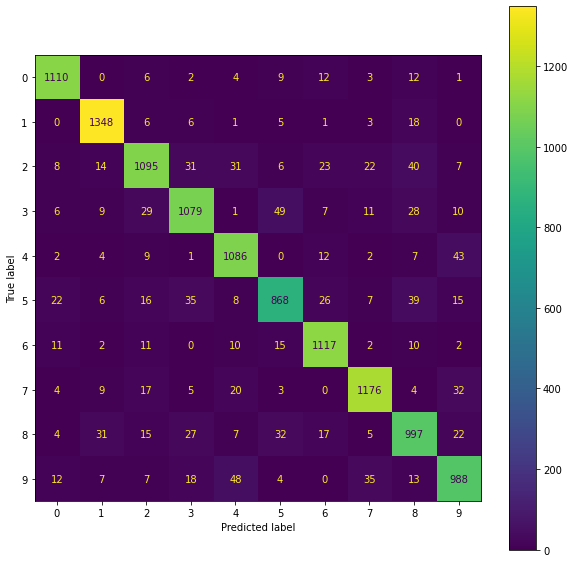

In [198]:
for x, y in test_dataloader:
    x = x.view(x.size(0), -1)
    mod.test(x, y, np.arange(0, 10))

<h3>Многослойный персептрон, классифицирующий датасет с точностью >85%</h3>

<h4>Модель</h4>

In [199]:
class Net(nn.Module):
    def __init__(self, countIn, countOut, countHidden = 150, actFunc = nn.ReLU()):
        super().__init__()
        self.fc1 = nn.Linear(countIn, countHidden)
        self.act1 = actFunc
        self.fc2 = nn.Linear(countHidden, countOut)
        self.act2 = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        return x

    def train(self, dataloader, epochs, learning_rate, p = False):
        opt = optim.SGD(self.parameters(), lr=learning_rate)
        loss_func = nn.CrossEntropyLoss()
        self.ep_loss = list()
        for e in range(epochs):
            losses = list()
            acc = list()
            for (x,y) in dataloader:
                x = x.view(x.size(0), -1)
                predictions = self(x)

                loss = loss_func(predictions,y)
                losses.append(loss.item())

                acc.append(tr.mean((tr.argmax(predictions, dim=1) == y).float()).item())

                opt.zero_grad()
                loss.backward()
                opt.step()
            loss = round(st.mean(losses), 3)
            self.losses = losses
            self.ep_loss.append(loss)
            accuracy = (int)(st.mean(acc) * 100)
            if (p): print(f"Epoch: {e}     loss: {loss} accuracy: {accuracy}%")
    
    def plot_ConfusionMatrix(self, y_true, y_pred, labels, title = ""):
        c_matr = metrics.confusion_matrix(y_true, y_pred) 
        disp = metrics.ConfusionMatrixDisplay(c_matr)
        fig, ax = plt.subplots(figsize=(10,10));
        disp.plot(ax=ax);
        ax.xaxis.set_ticklabels(labels);
        ax.yaxis.set_ticklabels(labels);
        disp.ax_.set_title("ConfusionMatrix " + title);

    def test(self, x, y, labels, title=""):
        predictions = self(x)
        val_predictions = tr.argmax(predictions, dim=1)
        
        acc = tr.mean((val_predictions == y).float())
        acc = (int)(acc * 100)

        print("Test:")
        print(f"Accuracy: {acc}%")

        self.plot_ConfusionMatrix(y.numpy(), val_predictions.detach().numpy(), labels, title)

<h4>Обучение:</h4>

In [200]:
net = Net(784, 10, actFunc=nn.Sigmoid())
print(net)
net.train(train_dataloader, 3, 0.01, True)

Net(
  (fc1): Linear(in_features=784, out_features=150, bias=True)
  (act1): Sigmoid()
  (fc2): Linear(in_features=150, out_features=10, bias=True)
  (act2): LogSoftmax(dim=1)
)
Epoch: 0     loss: 1.588 accuracy: 61%
Epoch: 1     loss: 0.662 accuracy: 84%
Epoch: 2     loss: 0.474 accuracy: 87%


<h4>Поведение функции потерь при обучении </h4>

<h5>Зависимость от числа нейронов в промежуточном слое</h5>

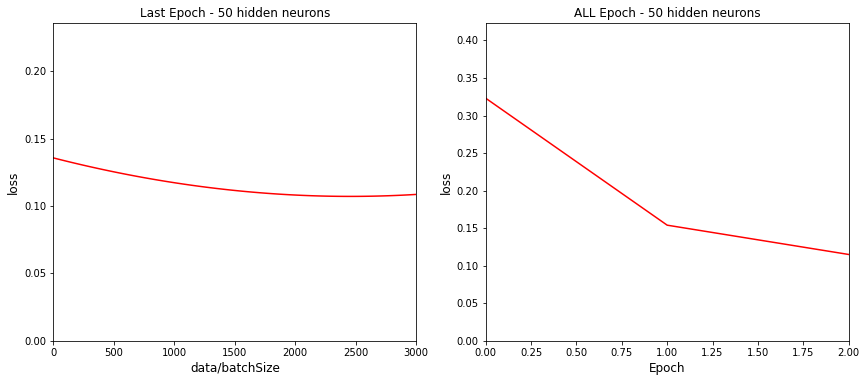

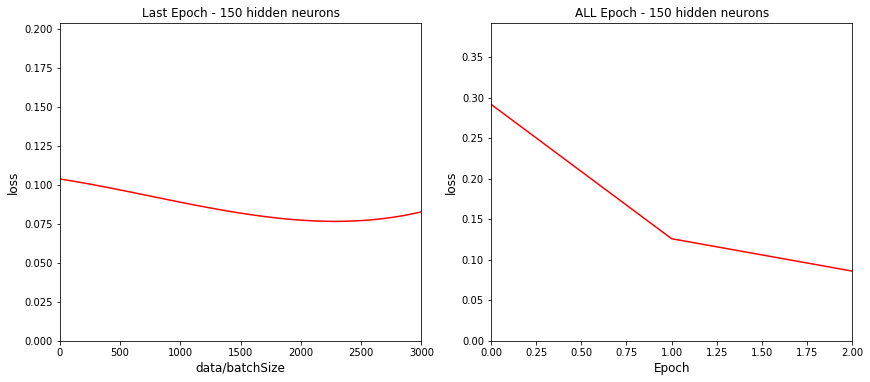

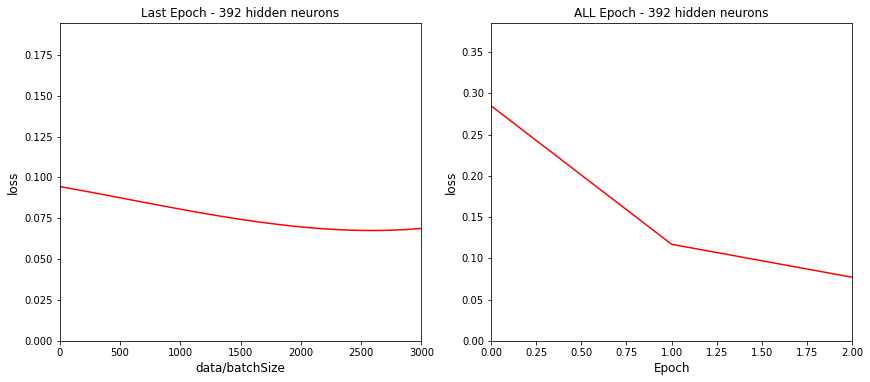

In [201]:
net01 = Net(784, 10, countHidden=50, actFunc=nn.ReLU())
net01.train(train_dataloader, 3, 0.1, False)
PlotLoss(np.arange(0, len(net01.losses)), net01.losses, "Last Epoch - 50 hidden neurons", np.arange(0, len(net01.ep_loss)), net01.ep_loss, "ALL Epoch - 50 hidden neurons")

net02 = Net(784, 10, countHidden=150, actFunc=nn.ReLU())
net02.train(train_dataloader, 3, 0.1, False)
PlotLoss(np.arange(0, len(net02.losses)), net02.losses, "Last Epoch - 150 hidden neurons", np.arange(0, len(net02.ep_loss)), net02.ep_loss, "ALL Epoch - 150 hidden neurons")

net03 = Net(784, 10, countHidden=392, actFunc=nn.ReLU())
net03.train(train_dataloader, 3, 0.1, False)
PlotLoss(np.arange(0, len(net03.losses)), net03.losses, "Last Epoch - 392 hidden neurons", np.arange(0, len(net03.ep_loss)), net03.ep_loss, "ALL Epoch - 392 hidden neurons")

<h5>Зависимость от типа передаточной функции</h5>

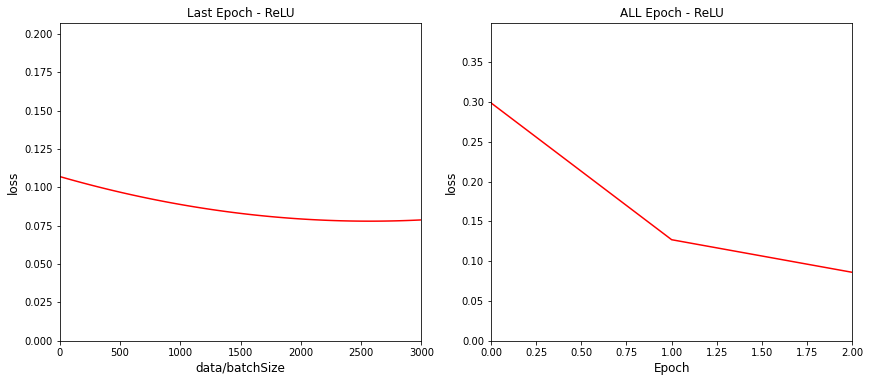

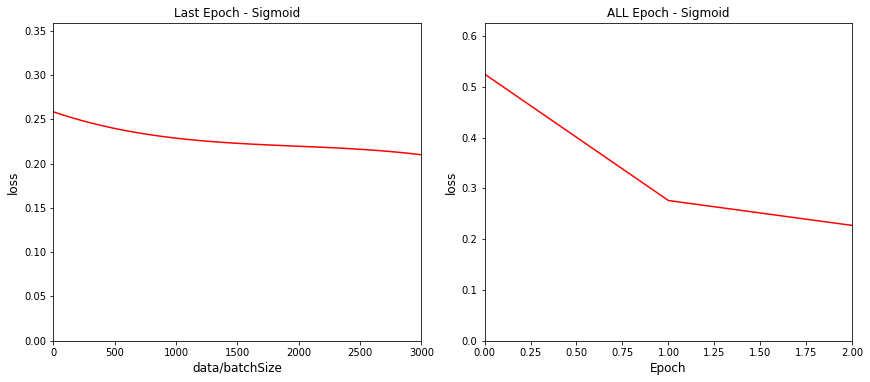

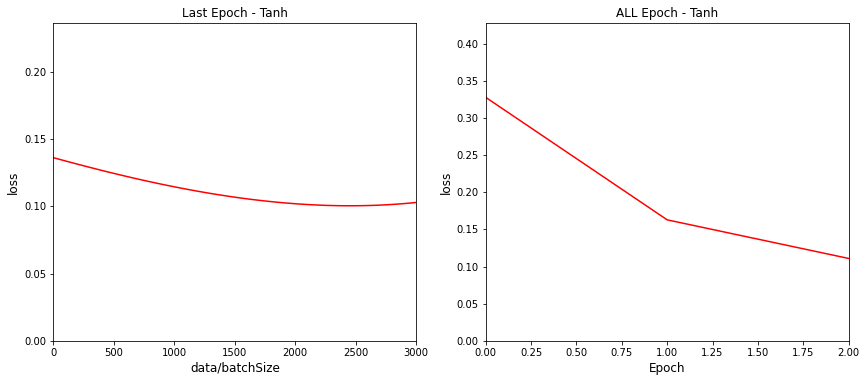

In [202]:
net1 = Net(784, 10, actFunc=nn.ReLU())
net1.train(train_dataloader, 3, 0.1, False)
PlotLoss(np.arange(0, len(net1.losses)), net1.losses, "Last Epoch - ReLU", np.arange(0, len(net1.ep_loss)), net1.ep_loss, "ALL Epoch - ReLU")

net2 = Net(784, 10, actFunc=nn.Sigmoid())
net2.train(train_dataloader, 3, 0.1, False)
PlotLoss(np.arange(0, len(net2.losses)), net2.losses, "Last Epoch - Sigmoid", np.arange(0, len(net2.ep_loss)), net2.ep_loss, "ALL Epoch - Sigmoid")

net3 = Net(784, 10, actFunc=nn.Tanh())
net3.train(train_dataloader, 3, 0.1, False)
PlotLoss(np.arange(0, len(net3.losses)), net3.losses, "Last Epoch - Tanh", np.arange(0, len(net3.ep_loss)), net3.ep_loss, "ALL Epoch - Tanh")

<h4>Тестирование:</h4>

Activation Function: ReLU
Test:
Accuracy: 96%

Activation Function: Sigmoid
Test:
Accuracy: 93%

Activation Function: Tanh
Test:
Accuracy: 96%


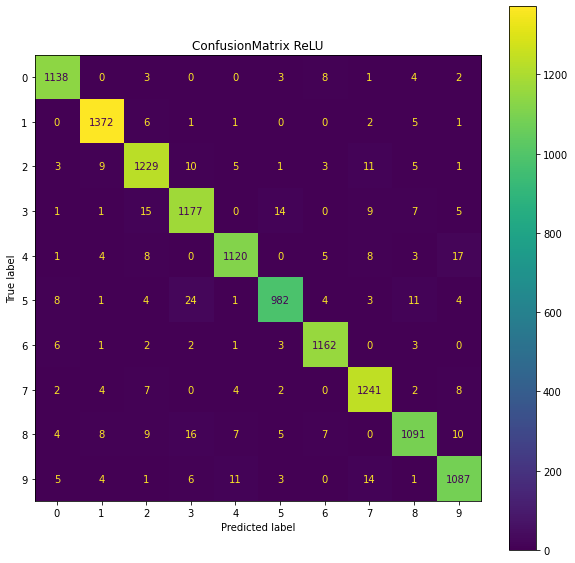

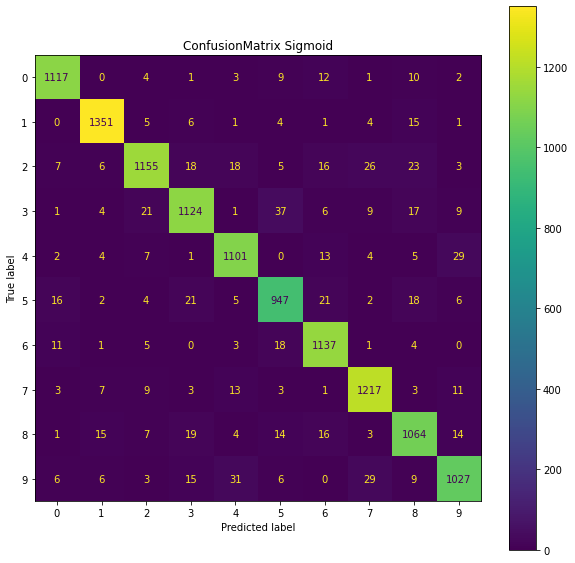

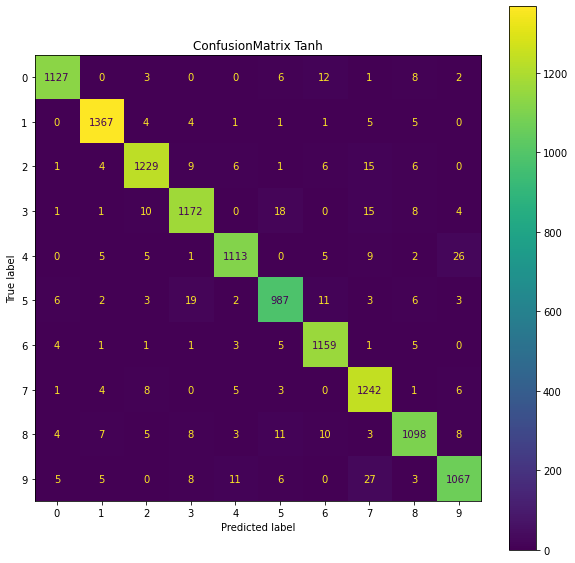

In [203]:
for x, y in test_dataloader:
    x = x.view(x.size(0), -1)
    print("Activation Function: ReLU")
    net1.test(x, y, np.arange(0, 10), "ReLU")
    
    print("\nActivation Function: Sigmoid")
    net2.test(x, y, np.arange(0, 10), "Sigmoid")
    
    print("\nActivation Function: Tanh")
    net3.test(x, y, np.arange(0, 10), "Tanh")

<h3>Данные для обучения(FashionMNIST):</h3>

One batch:
features: tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
labels: tensor([8, 5, 6, 2, 4, 1, 2, 9, 0, 9, 6, 7, 8, 0, 2, 1])


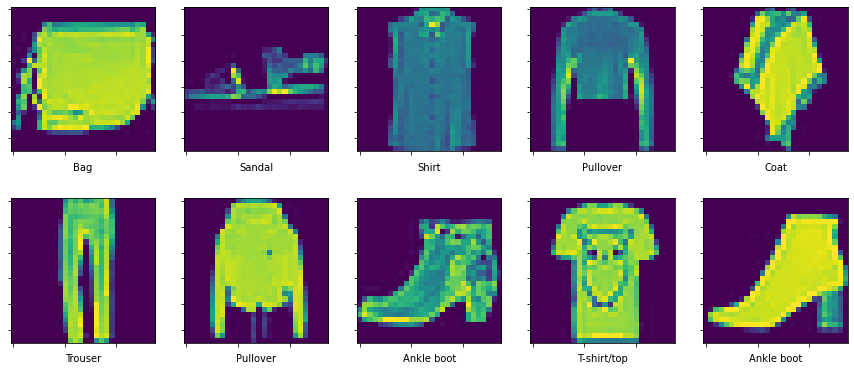

In [204]:
train_data = datasets.FashionMNIST('data', train=True, download=False, transform=transforms.ToTensor())
train_x, test_x = data.random_split(train_data, [len(train_data) * 8 // 10, len(train_data) - len(train_data) * 8 // 10])

train_dataloader = data.DataLoader(train_x, batch_size=16)
test_dataloader = data.DataLoader(test_x, batch_size=len(test_x))


x, y = iter(train_dataloader).next()
x = x.view(x.size(0), -1)
print("One batch:")
print(f"features: {x}")
print(f"labels: {y}")

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
fig = plt.figure(figsize=(15, 10))
for i in range(min(len(x), 10)):
    ax = fig.add_subplot(3, 5, i+1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.imshow(x[i].reshape(28, 28))
    plt.xlabel(labels[y[i].item()])
plt.show()

<h3>Однослойный персептрон</h3>

<h4> Обучение</h4>

In [205]:
mod = Model(784, 10, 0.01)
epoch = 5
ep_loss = list()
for e in range(epoch):
    acc = list()
    losses = list()
    for (x, y) in train_dataloader:
        x = x.view(x.size(0), -1)
        loss = mod.train(x, y)
        losses.append(loss.item())
        acc.append(mod.acc.item())
    loss = round(st.mean(losses), 3)
    ep_loss.append(loss)
    accuracy = (int)(st.mean(acc) * 100)
    print(f"Epoch: {e}     loss: {loss} accuracy: {accuracy}%")

Epoch: 0     loss: 0.744 accuracy: 75%
Epoch: 1     loss: 0.549 accuracy: 81%
Epoch: 2     loss: 0.508 accuracy: 82%
Epoch: 3     loss: 0.486 accuracy: 83%
Epoch: 4     loss: 0.472 accuracy: 84%


<h4> Тестирование:</h4>

Test:
Accuracy: 84%
ConfusionMatrix:


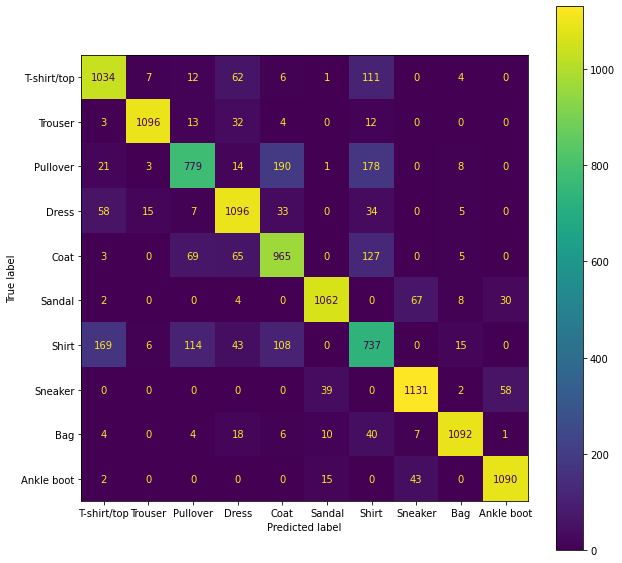

In [206]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
for x, y in test_dataloader:
    x = x.view(x.size(0), -1)
    mod.test(x, y, labels)

<h3>Многослойный персептрон</h3>

<h4> Обучение</h4>

Epoch: 0     loss: 0.551 accuracy: 79%
Epoch: 1     loss: 0.407 accuracy: 85%
Epoch: 2     loss: 0.367 accuracy: 86%


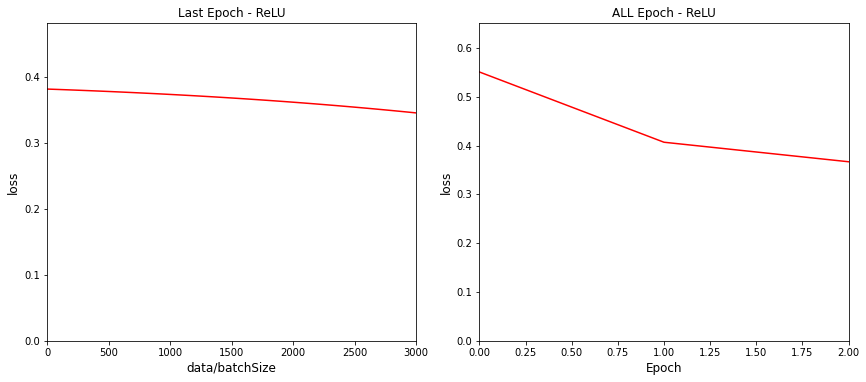

In [207]:
net1 = Net(784, 10, actFunc=nn.ReLU())
net1.train(train_dataloader, 3, 0.1, True)
PlotLoss(np.arange(0, len(net1.losses)), net1.losses, "Last Epoch - ReLU", np.arange(0, len(net1.ep_loss)), net1.ep_loss, "ALL Epoch - ReLU")

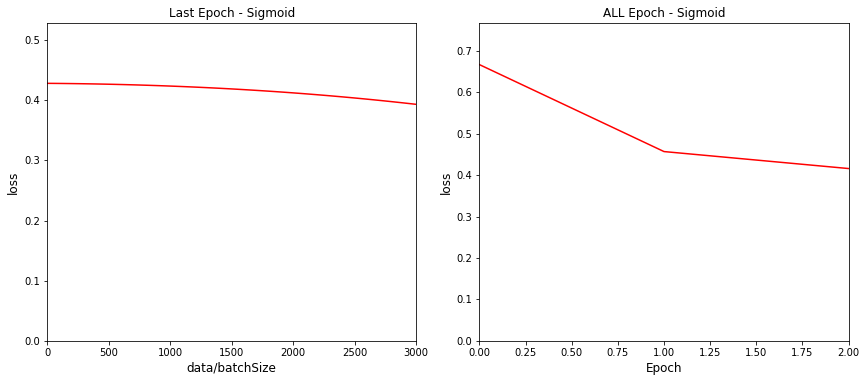

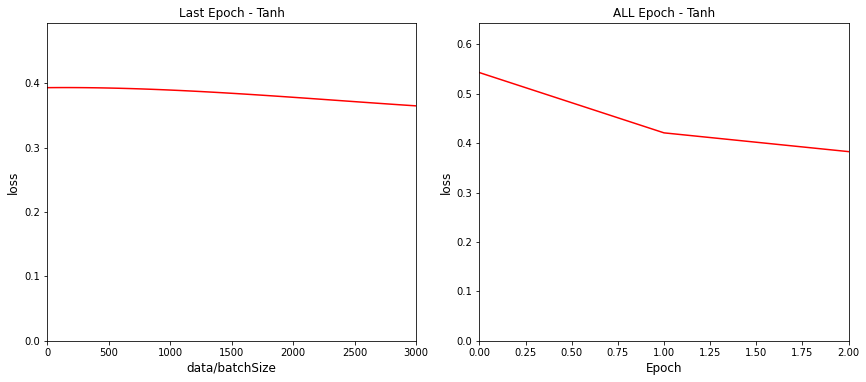

In [208]:
net2 = Net(784, 10, actFunc=nn.Sigmoid())
net2.train(train_dataloader, 3, 0.1, False)
PlotLoss(np.arange(0, len(net2.losses)), net2.losses, "Last Epoch - Sigmoid", np.arange(0, len(net2.ep_loss)), net2.ep_loss, "ALL Epoch - Sigmoid")

net3 = Net(784, 10, actFunc=nn.Tanh())
net3.train(train_dataloader, 3, 0.1, False)
PlotLoss(np.arange(0, len(net3.losses)), net3.losses, "Last Epoch - Tanh", np.arange(0, len(net3.ep_loss)), net3.ep_loss, "ALL Epoch - Tanh")

<h4> Тестирование:</h4>

Activation Function: ReLU
Test:
Accuracy: 86%

Activation Function: Sigmoid
Test:
Accuracy: 85%

Activation Function: Tanh
Test:
Accuracy: 86%


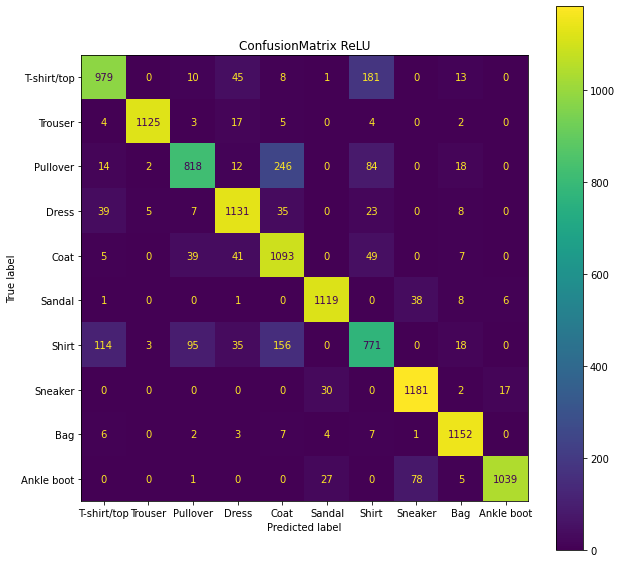

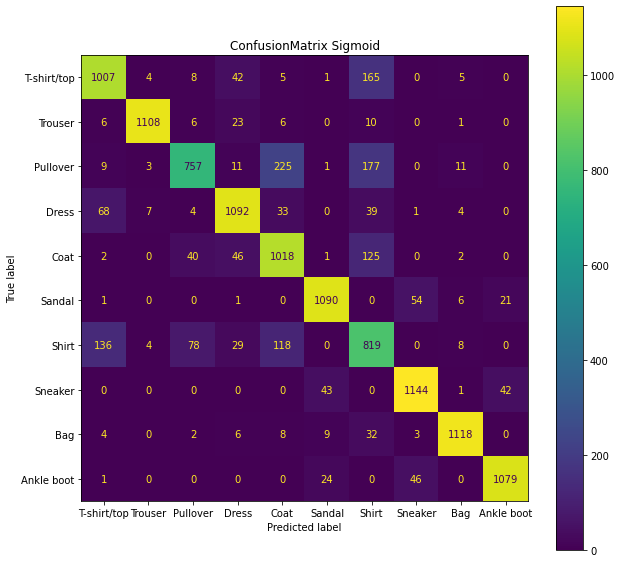

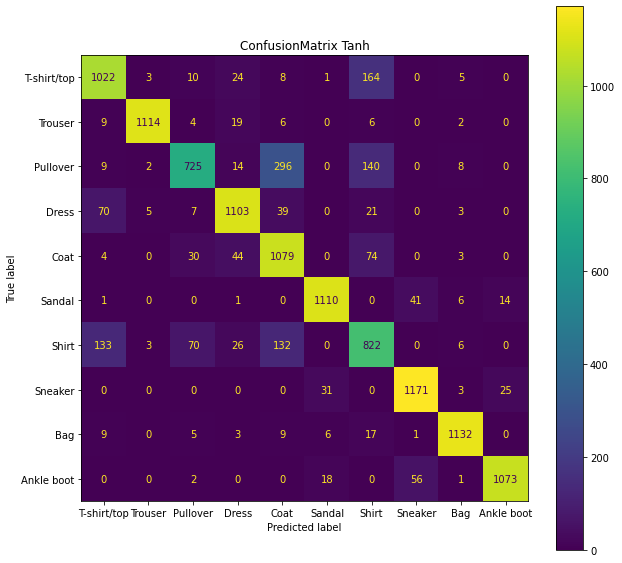

In [209]:
for x, y in test_dataloader:
    x = x.view(x.size(0), -1)
    print("Activation Function: ReLU")
    net1.test(x, y, labels, "ReLU")
    
    print("\nActivation Function: Sigmoid")
    net2.test(x, y, labels, "Sigmoid")
    
    print("\nActivation Function: Tanh")
    net3.test(x, y, labels, "Tanh")

<h3>Анализ </h3>

Test:
Accuracy: 84%
ConfusionMatrix:


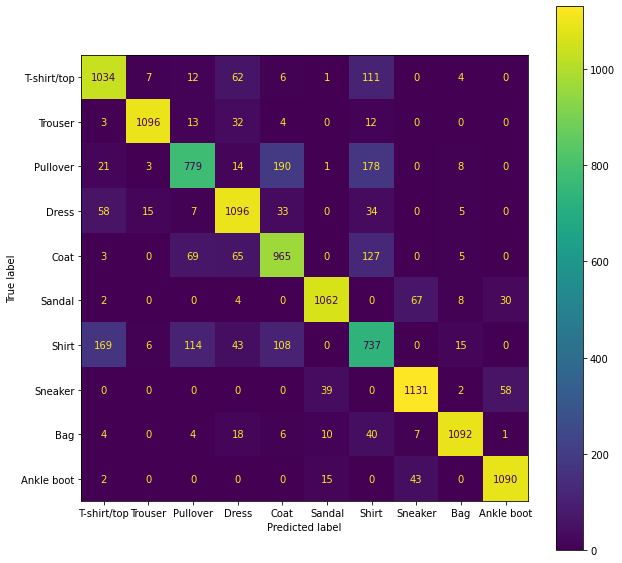

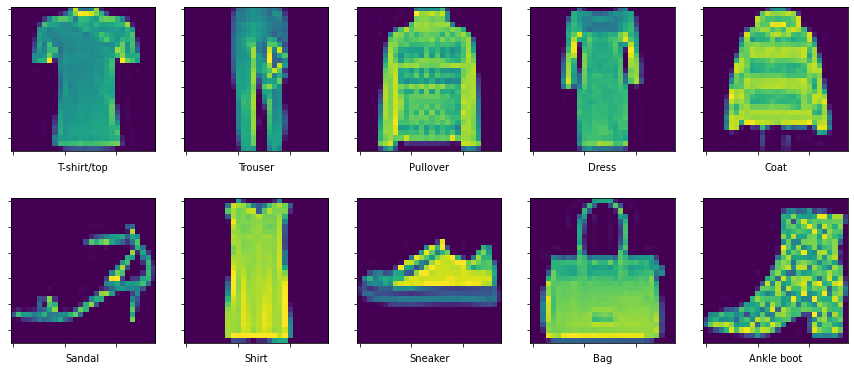

In [210]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
img = []
lab = []
j = 0

x, y = iter(test_dataloader).next()
x = x.view(x.size(0), -1)
y = y.numpy()
for i in range(len(y)):
    if j == y[i]:
        img.append(x[i])
        lab.append(labels[y[i]])
        j += 1
    if j == 10:
        break

for x, y in test_dataloader:
    x = x.view(x.size(0), -1)
    mod.test(x, y, labels)

fig = plt.figure(figsize=(15, 10))
for i in range(10):
    ax = fig.add_subplot(3, 5, i+1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.imshow(img[i].reshape(28, 28))
    plt.xlabel(lab[i])
plt.show()


Анализируя матрицу неточности можно увидеть, что наиболее точный результат выдается для Брюк. Это происходит потому, что брюки больше всего отличатся от остальных картинок. 

Также видно, что при тестировании хуже всего определяется Рубашка, это происходит потому, что рубашка на картинке выглядит похоже на Футболку(пиксели распологаются почти в одинаковых местах на картинках), по матнице неточности можно увидеть, что Рубашка и Футболка различаются хуже, чем, например Штаны и Футболка. 

Аналогичное поведение наблюдается у Свитера и Плаща.

Подводя итог, можно сделать вывод о том, что если картинки похожи друг на друга, мало отличатся по форме предмета(внутри картинки, для данного набора данных), то есть насыщенность пикселя на одной и той же позиции в разных картинках схожа, то картинки будут хуже распознаваться. 

<h3>Данные для обучения(CIFAR-10):</h3>

One batch:
features: tensor([[[[ 0.3098,  0.3804,  0.1843,  ..., -0.2157, -0.0118,  0.0431],
          [ 0.2157,  0.1608,  0.1216,  ...,  0.0510,  0.3020,  0.1686],
          [ 0.0510,  0.1373,  0.0824,  ...,  0.2314,  0.3490,  0.2000],
          ...,
          [-0.1608, -0.0510, -0.0980,  ...,  0.2078,  0.1294,  0.1059],
          [-0.2000,  0.0824, -0.1059,  ...,  0.1686,  0.3020,  0.3412],
          [-0.0745,  0.2078, -0.1686,  ...,  0.1059,  0.4118,  0.5059]],

         [[ 0.3804,  0.4510,  0.2706,  ..., -0.1843,  0.0431,  0.1294],
          [ 0.2863,  0.2157,  0.1765,  ...,  0.0745,  0.3569,  0.2471],
          [ 0.1216,  0.1765,  0.0980,  ...,  0.2549,  0.3961,  0.2863],
          ...,
          [-0.2235, -0.1137, -0.1608,  ...,  0.2235,  0.2078,  0.2157],
          [-0.2706,  0.0118, -0.1765,  ...,  0.1686,  0.3961,  0.4745],
          [-0.1451,  0.1373, -0.2392,  ...,  0.0980,  0.5059,  0.6471]],

         [[ 0.2078,  0.4039,  0.1608,  ..., -0.2941, -0.0588,  0.0431],
         

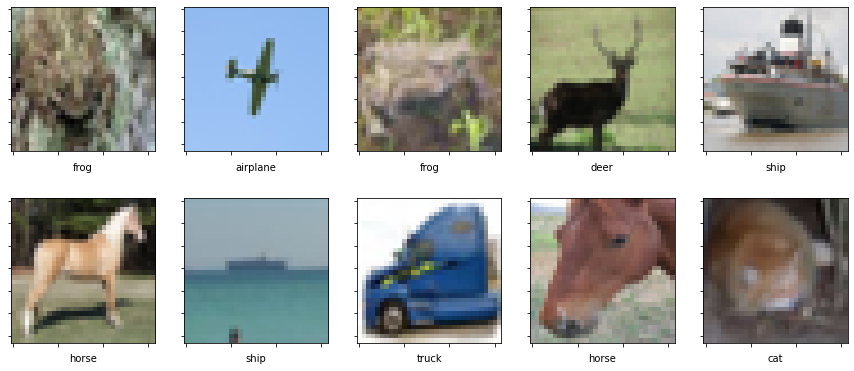

In [211]:
train_data = datasets.CIFAR10('data', train=True, download=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
train_x, test_x = data.random_split(train_data, [len(train_data) * 8 // 10, len(train_data) - len(train_data) * 8 // 10])

train_dataloader = data.DataLoader(train_x, batch_size=16)
test_dataloader = data.DataLoader(test_x, batch_size=len(test_x))


x, y = iter(train_dataloader).next()

print("One batch:")
print(f"features: {x}")
print(f"labels: {y}")

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
fig = plt.figure(figsize=(15, 10))
for i in range(min(len(x), 10)):
    ax = fig.add_subplot(3, 5, i+1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    img=x[i]*0.5+0.5
    plt.imshow(np.transpose(img,(1,2,0)))
    plt.xlabel(labels[y[i].item()])
plt.show()

<h3>Однослойный персептрон</h3>

<h4> Обучение</h>

In [212]:
mod = Model(3072, 10, 0.01)
epoch = 5
ep_loss = list()
for e in range(epoch):
    acc = list()
    losses = list()
    for (x, y) in train_dataloader:
        x = x.view(x.size(0), -1)
        loss = mod.train(x, y)
        losses.append(loss.item())
        acc.append(mod.acc.item())
    loss = round(st.mean(losses), 3)
    ep_loss.append(loss)
    accuracy = (int)(st.mean(acc) * 100)
    print(f"Epoch: {e}     loss: {loss} accuracy: {accuracy}%")

Epoch: 0     loss: 1.857 accuracy: 35%
Epoch: 1     loss: 1.778 accuracy: 38%
Epoch: 2     loss: 1.754 accuracy: 39%
Epoch: 3     loss: 1.739 accuracy: 40%
Epoch: 4     loss: 1.729 accuracy: 40%


<h4>Поведение функции потрерь при обучении <h4>

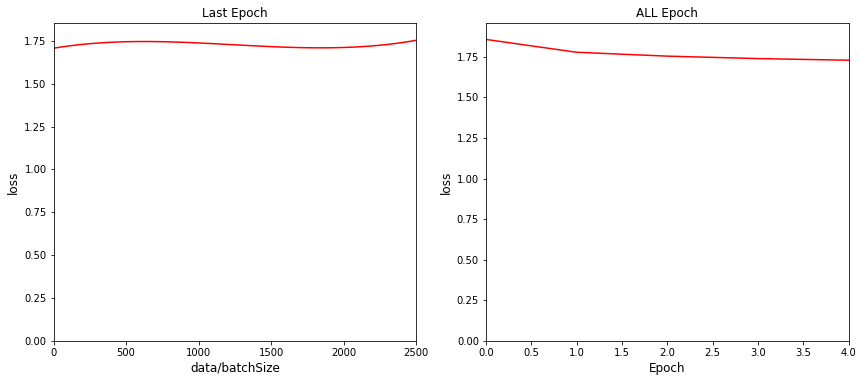

In [213]:
PlotLoss(np.arange(0, len(losses)), losses, "Last Epoch", np.arange(0, len(ep_loss)), ep_loss, "ALL Epoch")

<h4> Тестирование</h>

Test:
Accuracy: 38%
ConfusionMatrix:


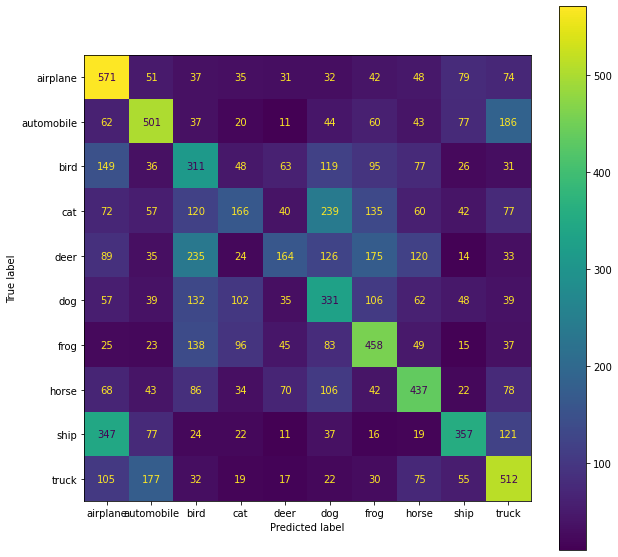

In [214]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
for x, y in test_dataloader:
    x = x.view(x.size(0), -1)
    mod.test(x, y, labels)

<h3>Многослойный персептрон</h3>

<h4> Обучение</h>

Epoch: 0     loss: 1.867 accuracy: 35%
Epoch: 1     loss: 1.77 accuracy: 40%
Epoch: 2     loss: 1.706 accuracy: 43%


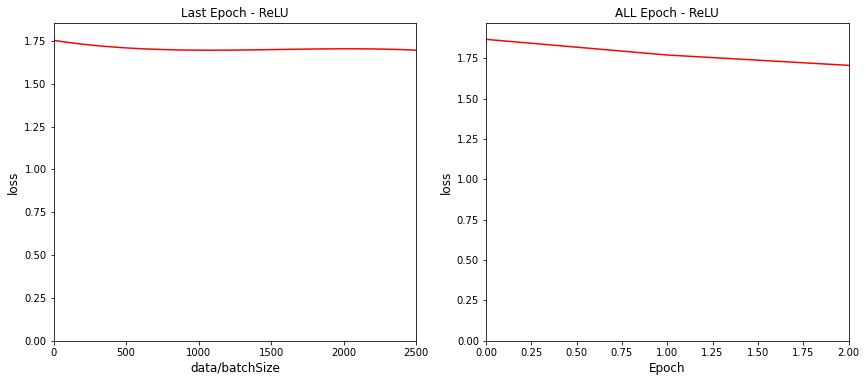

In [215]:
net1 = Net(3072, 10, countHidden=100, actFunc=nn.ReLU())
net1.train(train_dataloader, 3, 0.1, True)
PlotLoss(np.arange(0, len(net1.losses)), net1.losses, "Last Epoch - ReLU", np.arange(0, len(net1.ep_loss)), net1.ep_loss, "ALL Epoch - ReLU")

<h4> Тестирование</h>

Test:
Accuracy: 41%


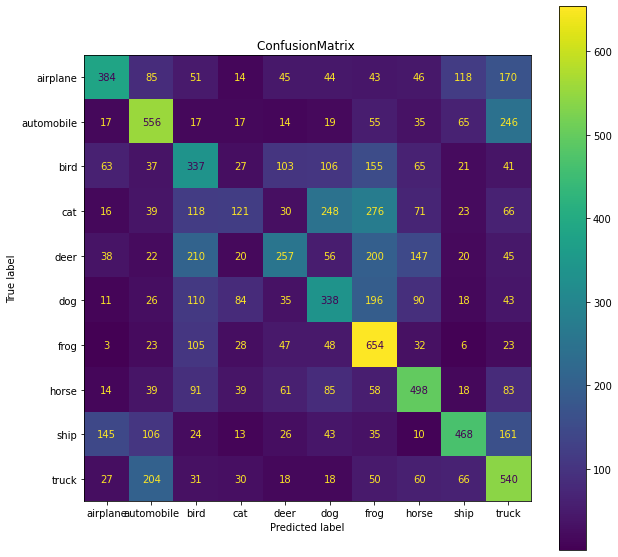

In [216]:
for x, y in test_dataloader:
    x = x.view(x.size(0), -1)
    net1.test(x, y, labels)

<h4>Анализ </h4>

Test:
Accuracy: 38%
ConfusionMatrix:


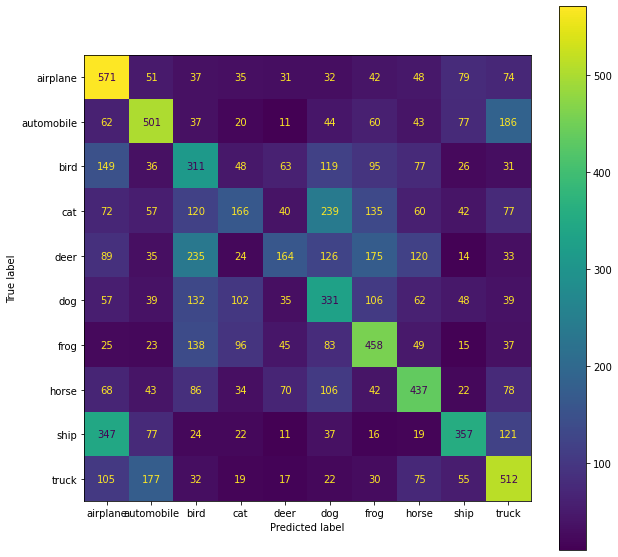

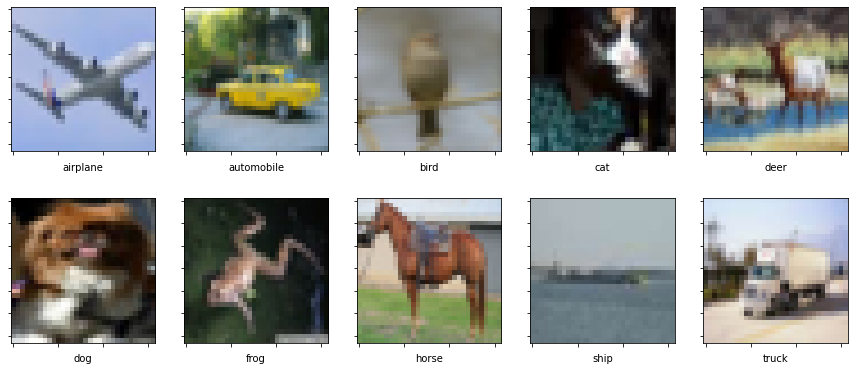

In [217]:
labels = labels = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
img = []
lab = []
j = 0

x, y = iter(test_dataloader).next()
y = y.numpy()
for i in range(len(y)):
    if j == y[i]:
        img.append(x[i])
        lab.append(labels[y[i]])
        j += 1
    if j == 10:
        break

for x, y in test_dataloader:
    x = x.view(x.size(0), -1)
    mod.test(x, y, labels)

fig = plt.figure(figsize=(15, 10))
for i in range(10):
    ax = fig.add_subplot(3, 5, i+1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    im=img[i]*0.5+0.5
    plt.imshow(np.transpose(im,(1,2,0)))
    plt.xlabel(lab[i])
plt.show()

Анализируя матрицу неточностей и точность на тестовых данных, можно сделать вывод о том, что реализованноя мной нейронная сень плохо анализирует этот датасет. Анализ происходит не точно, так как на данных картинках присутствует фон, который на одном и том же типе картинок может быть разный, а на разных типах картинкок может быть похож, что, по моему мнению, усложняет обучение, также изображения животных могут не сильно различаться. 
